In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
ds = xr.open_dataset('/home/sachin/Documents/NIPR/Research/Data/AMPERE/processed/ampere_omni_2010.nc')
ds

<xarray.Dataset> Size: 3GB
Dimensions:         (dt: 261165, mlat: 50, mlt: 24)
Coordinates:
  * dt              (dt) datetime64[ns] 2MB 2010-01-01 ... 2010-12-31T23:58:00
  * mlat            (mlat) float64 400B 50.0 50.82 51.63 ... 88.37 89.18 90.0
  * mlt             (mlt) float64 192B 0.0 1.043 2.087 3.13 ... 21.91 22.96 24.0
Data variables: (12/13)
    jPar            (dt, mlat, mlt) float64 3GB ...
    BX_GSE          (dt) float64 2MB ...
    BY_GSE          (dt) float64 2MB ...
    BZ_GSE          (dt) float64 2MB ...
    flow_speed      (dt) float64 2MB ...
    proton_density  (dt) float64 2MB ...
    ...              ...
    AU_INDEX        (dt) float64 2MB ...
    SYM_H           (dt) float64 2MB ...
    ASY_H           (dt) float64 2MB ...
    F10.7           (dt) float64 2MB ...
    Kp              (dt) float64 2MB ...
    doy             (dt) float64 2MB ...

In [5]:
# Initialize scalers for the target variable and input variables
target_scaler = MinMaxScaler()
input_scaler = MinMaxScaler()

# Extract the target variable and reshape for scaling
target_var = ds['jPar'].values  # shape (t (n), mlat (50), mlt (24))

# Extract and scale input variables (variables that are dependent only on 'dt')
input_vars = ['BX_GSE', 'BY_GSE', 'BZ_GSE', 'flow_speed', 'proton_density', 'AL_INDEX', 'AU_INDEX', 'SYM_H', 'ASY_H', 'F10.7', 'Kp']
input_data = np.array([ds[var].values for var in input_vars]).T  # shape (22320, number_of_vars)
input_data_scaled = input_scaler.fit_transform(input_data)

def create_sequences(target_data, input_data, lookback=30):
    X, y = [], []
    for i in range(len(target_data) - lookback):
        X.append(input_data[i:i+lookback].T)
        y.append(target_data[i+lookback])

    return np.array(X), np.array(y)

lookback = 30
X, y = create_sequences(target_var, input_data_scaled, lookback=lookback)

X.shape, y.shape

((261135, 11, 30), (261135, 50, 24))

In [6]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Calculate split indices
train_idx = int(len(X) * train_ratio)
val_idx = int(len(X) * (train_ratio + val_ratio))

# Perform the split
X_train, X_val, X_test = X[:train_idx], X[train_idx:val_idx], X[val_idx:]
y_train, y_val, y_test = y[:train_idx], y[train_idx:val_idx], y[val_idx:]

In [7]:

# Convert data to PyTorch tensors and move to device
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [18]:
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=30, hidden_size=64, num_layers=2, batch_first=True)
        self.fc = nn.Linear(64, 24 * 50)

    def forward(self, x, h=None):
        x, h = self.lstm(x, h)
        x = self.fc(x[:, -1, :])
        x = x.view(-1, 50, 24)
        return x, h

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
# Train the model
num_epochs = 25

for epoch in range(num_epochs):
    model.train()
    hidden = None
    for X_batch, y_batch in train_loader:
        if torch.isnan(X_batch).any():
            hidden = None  # Reset LSTM states on NaN detection
            continue

        # Forward pass
        outputs, hidden = model(X_batch, hidden)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_loss = 0
    hidden = None
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            if torch.isnan(X_batch).any():
                hidden = None  # Reset LSTM states on NaN detection
                continue

            outputs, hidden = model(X_batch, hidden)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.3e}, Validation Loss: {val_loss:.3e}')


Epoch [1/25], Loss: 1.983e-02, Validation Loss: 0.000e+00
Epoch [2/25], Loss: 1.886e-02, Validation Loss: 0.000e+00
Epoch [3/25], Loss: 1.808e-02, Validation Loss: 0.000e+00
Epoch [4/25], Loss: 1.742e-02, Validation Loss: 0.000e+00
Epoch [5/25], Loss: 1.682e-02, Validation Loss: 0.000e+00
Epoch [6/25], Loss: 1.625e-02, Validation Loss: 0.000e+00
Epoch [7/25], Loss: 1.571e-02, Validation Loss: 0.000e+00
Epoch [8/25], Loss: 1.516e-02, Validation Loss: 0.000e+00
Epoch [9/25], Loss: 1.461e-02, Validation Loss: 0.000e+00
Epoch [10/25], Loss: 1.405e-02, Validation Loss: 0.000e+00
Epoch [11/25], Loss: 1.349e-02, Validation Loss: 0.000e+00
Epoch [12/25], Loss: 1.295e-02, Validation Loss: 0.000e+00
Epoch [13/25], Loss: 1.243e-02, Validation Loss: 0.000e+00
Epoch [14/25], Loss: 1.193e-02, Validation Loss: 0.000e+00
Epoch [15/25], Loss: 1.147e-02, Validation Loss: 0.000e+00
Epoch [16/25], Loss: 1.104e-02, Validation Loss: 0.000e+00
Epoch [17/25], Loss: 1.066e-02, Validation Loss: 0.000e+00
Epoch 

Test Loss: nan


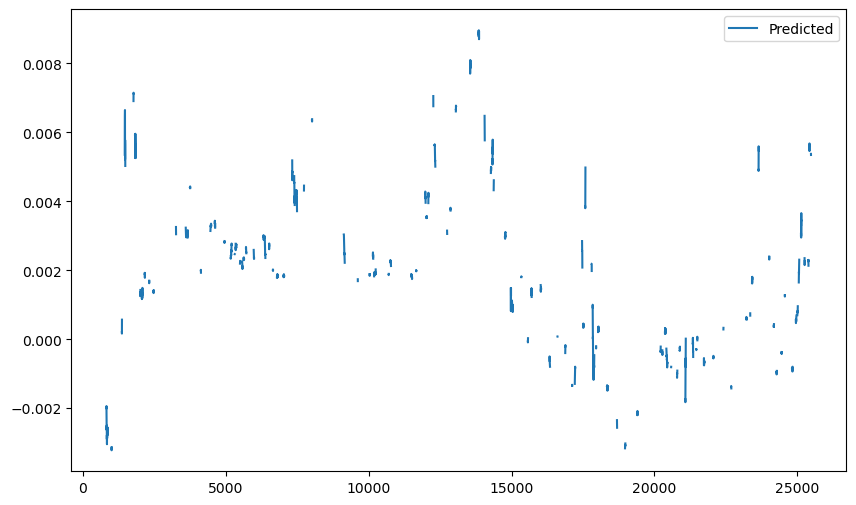

In [23]:
# Evaluate the model on the test set
model.eval()
model = model.cpu()  # Move model to CPU
X_test = X_test.cpu()  # Move test data to CPU
y_test = y_test.cpu()  # Move test targets to CPU

hidden = None
with torch.no_grad():
    predictions = model(X_test, hidden)[0]
    test_loss = criterion(predictions, y_test)
    print(f'Test Loss: {test_loss.item():.3e}')

mlat_idx = 1  #0 through 49
mlt_idx = 12 #0 through 23

plt.figure(figsize=(10, 6))
#plt.plot(y_test[:, mlat_idx, mlt_idx], label='Actual')
plt.plot(predictions[:, mlat_idx, mlt_idx], label='Predicted')
plt.legend()



In [ ]:
RMSE = np.sqrt(np.mean((predictions_rescaled - y_test_rescaled)**2))
NRMSE = RMSE / (np.max(y_test_rescaled) - np.min(y_test_rescaled))
R = np.corrcoef(predictions_rescaled.flatten(), y_test_rescaled.flatten())[0, 1]

print(f'RMSE: {RMSE:.4f}')
print(f'NRMSE: {NRMSE:.4f}')
print(f'R: {R:.4f}')